## 1- Filter CVD Death Patients
Remove all the NON-CVD death patients. Here we take in input the original dataset and output the original dataset with only CVD Death patients:
- Input: data.csv
- Output: data_cvd.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [2]:
# load data
df = pd.read_csv("./data/data/data.csv", index_col=0, decimal='.')
df_date = pd.read_csv("./data/data/extra_date.csv", index_col=0)
df = pd.merge(df, df_date, left_index=True, right_index=True)
df.convert_dtypes()
df["Follow Up Data"] = pd.to_datetime(df["Follow Up Data"], format="%m/%d/%Y")
df["Data prelievo (1)"] = pd.to_datetime(df["Data prelievo (1)"], format="%m/%d/%Y")

In [3]:
# remove ONLY and ALL the deaths patients NON-CVD (Fatal MI or Sudden death, UnKnown, Accident, Suicide)
total = df[df["Total mortality"]==1].index
cvd_idx = df[df["CVD Death"]==1].index
noncvd_idx = set(total) - set(cvd_idx)

# print(f"Total deaths: {len(total)}")
# print(f"Death CVD: {len(cvd_idx)}")
# print(f"Death Non-CVD: {len(noncvd_idx)}")

df_cvd = df.drop(noncvd_idx)
print(f"\nTotal patients: {len(df)}")
print(f"Total patients (after removal of Death Non-CVD): {len(df_cvd)}")
df.info()

assert len(noncvd_idx) == len(total) - len(cvd_idx)
assert len(df.columns) == len(df_cvd.columns)
# df_cvd.to_csv("data/data/data_cvd.csv")


Total patients: 5820
Total patients (after removal of Death Non-CVD): 4762
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5820 entries, 395 to 1193
Data columns (total 93 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Age (1)                                     5820 non-null   int64         
 1   Gender (Male = 1)                           5820 non-null   int64         
 2   Angina                                      5820 non-null   int64         
 3   Previous CABG                               5820 non-null   int64         
 4   Previous PCI                                5820 non-null   int64         
 5   Previous 
Myocardial Infarction             5820 non-null   int64         
 6   Acute 
Myocardial Infarction                5820 non-null   int64         
 7   Angiography                                 5820 non-null   int64         
 8   Vessels   

## 2- Clean Irrelevant Features
From the only CVD death patients, we remove all the irrelevant features for the classification task. We also create a target feature. 
- Input: data_cvd.csv
- Output: data_cvd_clean.csv

In [4]:
df_cvd = pd.read_csv("./data/data/data_cvd.csv", index_col=0, decimal='.')
df_cvd["Follow Up Data"] = pd.to_datetime(df_cvd["Follow Up Data"])
df_cvd["Data prelievo (1)"] = pd.to_datetime(df_cvd["Data prelievo (1)"])

Text(0, 0.5, 'Number of patients')

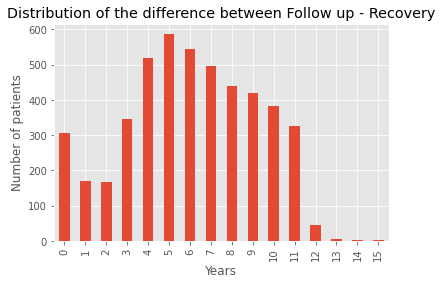

In [5]:
# compute difference between dates: follow up and admission
df_diff = (df_cvd["Follow Up Data"] - df_cvd["Data prelievo (1)"]).map(lambda x: x.days // 365)
df_diff.value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of the difference between Follow up - Recovery")
plt.xlabel("Years")
plt.ylabel("Number of patients")


In [6]:
# complete vessels feature, if CAD == 0 then Vessels can be set to 0, otherwise we don't know the Vessels
for i in df_cvd.index:
    if (pd.isna(df_cvd["Vessels"][i]) and df_cvd["CAD"][i]==0):
        df_cvd.loc[i, "Vessels"] = 0
    elif (pd.isna(df_cvd["Vessels"][i]) and df_cvd["CAD"][i]==1):
        df_cvd.loc[i, "Vessels"] = -1

# clean features remove follow up features
df_feat = df_cvd.copy()
df_feat = pd.concat([df_feat.iloc[:, :30], df_feat.iloc[:, 40:]], axis=1)
df_feat = df_feat.drop(columns=["Patologia TIROIDE ", "Controllo", "Weight", "Height",
                                "AMI", "CABG ", "Cardiac cause of death", "Cause of death",
                                "Collected by", "Data of death", "Data prelievo (1)", "Follow Up Data",
                                "Ictus", "Non Fatal AMI (Follow-Up)", "PCI", "PMI"])

# create and add target feature
years = 7
survive = (df_diff < years) & df_cvd["CVD Death"]
survive = (survive + 1) % 2
df_feat[f"Survive{years}Y"] = survive

print("Total patient: \t", len(df_feat))
print("Survived: \t", df_feat[f"Survive{years}Y"].sum(), "\t", df_feat[f"Survive{years}Y"].sum()/len(df_feat))
print("Dead: \t\t", len(df_feat)-df_feat[f"Survive{years}Y"].sum(), "\t", (len(df_feat)-df_feat[f"Survive{years}Y"].sum())/len(df_feat))
df_feat = df_feat.convert_dtypes()
df_feat.info()

# df_feat.to_csv("data/data/data_cvd_clean.csv")

Total patient: 	 4762
Survived: 	 4406 	 0.9252414951700966
Dead: 		 356 	 0.0747585048299034
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4762 entries, 8986 to 1193
Data columns (total 68 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Age (1)                                     4762 non-null   Int64  
 1   Gender (Male = 1)                           4762 non-null   Int64  
 2   Angina                                      4762 non-null   Int64  
 3   Previous CABG                               4762 non-null   Int64  
 4   Previous PCI                                4762 non-null   Int64  
 5   Previous 
Myocardial Infarction             4762 non-null   Int64  
 6   Acute 
Myocardial Infarction                4762 non-null   Int64  
 7   Angiography                                 4762 non-null   Int64  
 8   Vessels                                     4762 non-null   F

## 3- Add Extra Subset Information
From the CVD-cleaned dataset, we add further information about subsets. These subsets are used for classifying specific group of patients
- Input: data_cvd_clean.csv
- Output: data_cvd_clean_subset.csv

In [7]:
df_subset = pd.read_csv("./data/data/data_cvd_clean.csv", index_col=0, decimal='.')
df_sub = pd.read_csv("./data/data/extra_subset.csv", index_col=0, decimal='.')

Text(0, 0.5, 'Categories')

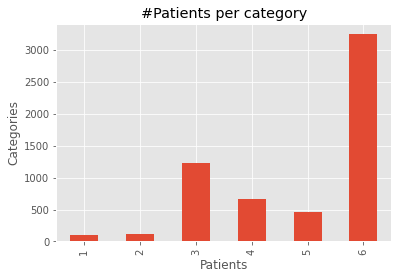

In [8]:
# number of patients per category
df_sub["Classificazione pazienti"].value_counts().sort_index().plot(kind='bar')
plt.title("#Patients per category")
plt.xlabel("Patients")
plt.ylabel("Categories")

In [9]:
# correct the old dataset with the new data, which has some corrections
df_subset = df_subset.sort_index(ascending=True)
df_sub_clean = df_sub.drop(list(set(df_sub.index) - set(df_subset.index)))
assert (df_subset.index == df_sub_clean.index).all
# sum(df_sub_clean["Previous \nMyocardial Infarction - PMI"] == df["Previous \nMyocardial Infarction"])

df_subset["Previous \nMyocardial Infarction"] = df_sub_clean["Previous \nMyocardial Infarction - PMI"]
df_subset["Angiography"] = df_sub_clean["Angiography"]
df_subset["Documented resting \nor exertional ischemia"] = df_sub_clean["Documented resting \nor exertional ischemia"]
df_subset["Post-ischemic Dilated\nCardiomyopathy"] = df_sub_clean["Post-ischemic Dilated\nCardiomyopathy"]
df_subset["Primary Dilated\nCardiomyopathy"] = df_sub_clean["Primary Dilated\nCardiomyopathy"]

In [10]:
# feature engineering
df_subset = df_subset.copy()
df_subset["MIO"] = df_subset["MIN"] | df_subset["MIO"]
df_subset.rename(columns={"MIO": "MIO/MIN"}, inplace=True)
df_subset = df_subset.drop(columns=["MIN", "Angiography"])

# fix all the NA patients
# 1. remove Suriveve7Y = 1 and NA
# 2. fill other NA's HR = average(HR of Survive7Y = 0) = 76
df_na = df_subset[df_subset.isna().any(axis=1)]
df_subset = df_subset.drop(df_na[df_na["Survive7Y"] == 1].index)
df_subset.loc[df_na[df_na["Survive7Y"] == 0].index, "HR"] = 76

years = 7
print("Total patient: \t", len(df_subset))
print("Survived: \t", df_subset[f"Survive{years}Y"].sum(), "\t", df_subset[f"Survive{years}Y"].sum()/len(df_subset))
print("Dead: \t\t", len(df_subset)-df_subset[f"Survive{years}Y"].sum(), "\t", (len(df_subset)-df_subset[f"Survive{years}Y"].sum())/len(df_subset))
df_subset.info()

# df_subset.to_csv("data/data/data_cvd_clean_subset.csv")

Total patient: 	 4734
Survived: 	 4378 	 0.9247993240388678
Dead: 		 356 	 0.07520067596113224
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4734 entries, 3 to 9085
Data columns (total 66 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Age (1)                                     4734 non-null   int64  
 1   Gender (Male = 1)                           4734 non-null   int64  
 2   Angina                                      4734 non-null   int64  
 3   Previous CABG                               4734 non-null   int64  
 4   Previous PCI                                4734 non-null   int64  
 5   Previous 
Myocardial Infarction             4734 non-null   int64  
 6   Acute 
Myocardial Infarction                4734 non-null   int64  
 7   Vessels                                     4734 non-null   float64
 8   CAD                                         4734 non-null   int

## 4- Remove the medicines
Remove all the medicines from the dataset
- Input: data_cvd_clean_subset.csv
- Output: data_cvd_clean_subset_nomeds.csv

In [11]:
df_subset = pd.read_csv("./data/data/data_cvd_clean_subset.csv", index_col=0, decimal='.')
df_subset.info()

In [13]:
df_subset_nomeds = df_subset.drop(columns=[
                                "B-Blockers",
                                "Amiodarone",
                                "Calcium channel blockers",
                                "Diuretics",
                                "Antiplatelet",
                                "Nitrates",
                                "ACE-inhibitors",
                                "Ipolipemizzanti",
                                "Antidiabetici",
                            ])

# df_subset_nomeds.info()
# df_subset_nomeds.to_csv("data/data/data_cvd_clean_subset_nomeds.csv")
df_subset_nomeds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4734 entries, 3 to 9085
Data columns (total 57 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Age (1)                                     4734 non-null   int64  
 1   Gender (Male = 1)                           4734 non-null   int64  
 2   Angina                                      4734 non-null   int64  
 3   Previous CABG                               4734 non-null   int64  
 4   Previous PCI                                4734 non-null   int64  
 5   Previous 
Myocardial Infarction             4734 non-null   int64  
 6   Acute 
Myocardial Infarction                4734 non-null   int64  
 7   Vessels                                     4734 non-null   float64
 8   CAD                                         4734 non-null   int64  
 9   Smoke
History of smoke                      4734 non-null   int64  
 10  Diabetes
His

## 5- Remove many redundant features
Remove many redundant features
- Input: data_cvd_clean_subset_nomeds.csv
- Output: data_cvd_clean_subset_nomeds_noredundant.csv

In [14]:
df_subset = pd.read_csv("./data/data/data_cvd_clean_subset_nomeds.csv", index_col=0, decimal='.')
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4734 entries, 3 to 9085
Data columns (total 57 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Age (1)                                     4734 non-null   int64  
 1   Gender (Male = 1)                           4734 non-null   int64  
 2   Angina                                      4734 non-null   int64  
 3   Previous CABG                               4734 non-null   int64  
 4   Previous PCI                                4734 non-null   int64  
 5   Previous 
Myocardial Infarction             4734 non-null   int64  
 6   Acute 
Myocardial Infarction                4734 non-null   int64  
 7   Vessels                                     4734 non-null   float64
 8   CAD                                         4734 non-null   int64  
 9   Smoke
History of smoke                      4734 non-null   int64  
 10  Diabetes
His

In [31]:
print(df_subset_nomeds["Documented resting \nor exertional ischemia"].sum())
print(df_subset_nomeds["Angina"].sum())
print()

print(df_subset_nomeds["Paroxysmal atrial fibrillation"].sum())
print(df_subset_nomeds["Atrial Fibrillation"].sum())
print()

print(df_subset_nomeds["Normal"].sum())
print(df_subset_nomeds["SindromeX"].sum())
print(df_subset_nomeds["MIO/MIN"].sum())
print(df_subset_nomeds["Miocardite"].sum())
print(df_subset_nomeds["Pericardite"].sum())
print(df_subset_nomeds["Endocardite"].sum())
print(df_subset_nomeds["CardiopatiaCongenita"].sum())
print()

print(df_subset_nomeds["Ipertensione"].sum())
print(df_subset_nomeds["Hypertension\nHistory of hypertension"].sum())


2006
2513

198
865

76
8
54
22
54
13
72

2618
2891


In [ ]:
df_subset_noredundant = df_subset_nomeds.drop(columns=[
                                "Documented resting \nor exertional ischemia",
                                "Paroxysmal atrial fibrillation",
                                "Normal",
                                "SindromeX",
                                "MIO/MIN",
                                "Miocardite"
                                "Pericardite"
                                "Endocardite"
                                "CardiopatiaCongenita"
                                "Ipertensione"
                            ])

## Extra utilities
Create and save the subset datagroups

In [49]:
# dataset train, valid, test split
def split_and_save(df, path, verbose=True):
    from sklearn.model_selection import train_test_split
    df_train, df_test = train_test_split(df, test_size=0.2, stratify=df.iloc[:,-1])
    df_train, df_valid = train_test_split(df_train, test_size=0.2, stratify=df_train.iloc[:,-1])

    df_train.to_csv(f"{path}train.csv")
    df_valid.to_csv(f"{path}valid.csv")
    df_test.to_csv(f"{path}test.csv")

    if verbose: 
        print("Train: \t", len(df_train))
        print("Valid: \t", len(df_valid))
        print("Test: \t", len(df_test))

In [50]:
# number of patients for each subgroup
# - 6 Coronary Artery Disease
# - 5 Cardiomiopatia Dilatative Primitiva
# - 4 Miocardite, Pericardite, Endocardite... 
# - 3 Ipertensione, Aritmie

# divide into subgroups and save the datasets
df_6 = df_subset_nomeds[df_sub_clean["Classificazione pazienti"] == 6]
df_5 = df_subset_nomeds[df_sub_clean["Classificazione pazienti"] == 5]
df_4 = df_subset_nomeds[df_sub_clean["Classificazione pazienti"] == 4]
df_3 = df_subset_nomeds[df_sub_clean["Classificazione pazienti"] == 3]

# split_and_save(df_6, "data/data/7y_subset/6CAD/")
# split_and_save(df_5, "data/data/7y_subset/5CDP/")
# split_and_save(df_4, "data/data/7y_subset/4Cardite_Altro/")
# split_and_save(df_3, "data/data/7y_subset/3Ipertensione_Aritmie/")
# split_and_save(df_subset, "data/data/7y_subset/complete/")

<ipython-input-50-a3016289637e>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_6 = df_subset_nomeds[df_sub_clean["Classificazione pazienti"] == 6]
<ipython-input-50-a3016289637e>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_5 = df_subset_nomeds[df_sub_clean["Classificazione pazienti"] == 5]
<ipython-input-50-a3016289637e>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_4 = df_subset_nomeds[df_sub_clean["Classificazione pazienti"] == 4]
<ipython-input-50-a3016289637e>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_3 = df_subset_nomeds[df_sub_clean["Classificazione pazienti"] == 3]


In [79]:
# save the CAD subset removing the medicines features
df_train = pd.read_csv("data/data/7y_subset/6CAD/train.csv", index_col=0, decimal='.')
df_valid = pd.read_csv("data/data/7y_subset/6CAD/valid.csv", index_col=0, decimal='.')
df_test = pd.read_csv("data/data/7y_subset/6CAD/test.csv", index_col=0, decimal='.')
assert len(set(df_train.columns) - set(df_6.columns)) == 9

df_train_nomeds = df_6.loc[df_train.index, :]
df_valid_nomeds = df_6.loc[df_valid.index, :]
df_test_nomeds = df_6.loc[df_test.index, :]
assert len(df_train_nomeds) == len(df_train)

# df_train_nomeds.to_csv("data/data/7y_subset_nomeds/6CAD/train.csv")
# df_valid_nomeds.to_csv("data/data/7y_subset_nomeds/6CAD/valid.csv")
# df_test_nomeds.to_csv("data/data/7y_subset_nomeds/6CAD/test.csv")

In [52]:
from collections import Counter
print(Counter(df_6["Survive7Y"]))
print(Counter(df_5["Survive7Y"]))
print(Counter(df_4["Survive7Y"]))
print(Counter(df_3["Survive7Y"]))

Counter({1: 2406, 0: 213})
Counter({1: 318, 0: 41})
Counter({1: 460, 0: 66})
Counter({1: 1009, 0: 35})


In [85]:
print(Counter(df_train_nomeds["Survive7Y"]))
print(Counter(df_valid_nomeds["Survive7Y"]))
print(Counter(df_test_nomeds["Survive7Y"]))

Counter({1: 1606, 0: 142})
Counter({1: 402, 0: 36})
Counter({1: 398, 0: 35})


In [25]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(35,30))
sns.heatmap(df_feat.corr(), annot=True)
# fig.savefig("feat.pdf")